In [22]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from models import DenseModel

## Dataset

<div style="text-align: justify;">
The dataset filtered in the previous phase (random_samples.pkl) was imported. Only five lines were used for this phase, a decision justified by the limited computing power available. This reduced approach allows for quick and adjustable experimentation, in line with the good practices described in the study by Baptista et al. (2022), which emphasises the need to make iterative methodological adjustments to better understand the impact of different choices on Deep Learning (DL) models.
The use of a smaller subset of data can be considered as a strategic step to quickly validate hypotheses and adjust model architectures before expanding the analysis to the full dataset.
</div>

In [2]:
random_samples=pd.read_pickle(filepath_or_buffer= "random_samples.pkl")

In [3]:
random_samples.shape


(5000, 148)

In [4]:
random_samples[:5]

,Drug_ID,Cell_ID,SMILES,morgan_fingerprints,MaxAbsEStateIndex,MaxEStateIndex,MinEStateIndex,SPS,MolWt,HeavyAtomMolWt,...,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_unbrch_alkane,Gene_expression,Tissue,Y
141393,Navitoclax,IM-95,CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.177964,14.177964,-6.052872,18.338462,974.634,919.194,...,0,0,0,1,0,0,0,"[7.6500094247132004, 8.96961704119229, 4.47194...",digestive_system,1.045075
85325,Olaparib,NCI-H2342,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCN(C(...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.563571,14.563571,-0.574516,16.406250,434.471,411.287,...,0,0,0,1,0,0,0,"[7.544027123696081, 9.42565301675235, 4.517643...",lung,4.434202
29065,Tretinoin,JAR,CC(C=CC1=C(C)CCCC1(C)C)=CC=CC(C)=CC(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.534005,10.534005,-0.912324,20.227273,300.442,272.218,...,0,0,0,0,0,0,0,"[8.88583374567413, 9.99907378277568, 4.6891134...",urogenital_system,3.803186
88450,CHIR-99021,NCI-H727,Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.842475,8.842475,0.451511,10.562500,465.348,447.204,...,0,0,0,0,0,1,1,"[6.60749621672243, 9.572145847243029, 4.286476...",lung,1.800000
83157,QS11,T98G,COc1cc2c(cc1OC)CN(C(C)C(=O)Nc1cc([N+](=O)[O-])...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12.754640,12.754640,-0.529126,14.620690,419.865,397.689,...,0,0,0,0,0,0,0,"[5.66385108657489, 9.90868199023178, 3.9898832...",nervous_system,4.572616


## Dataset Split

<div style="text-align: justify;">
We took the filtered dataset (random_samples.pkl) and kept the columns we wanted to work on in the model (‘morgan_fingerprints’, ‘Gene_expression’ and ‘label’).
Next, the dataset was split, leaving 60 per cent of the data for training, 20 per cent for testing and 20 per cent for validation.
The data was then split into three different datasets: the one containing the morgan_fingerprints; the one containing the Gene_expression and the one containing the labels.
</div>

In [5]:
output = random_samples['Y']
input= random_samples[['morgan_fingerprints', 'Gene_expression']]


In [6]:
x_train, x_val, y_train, y_val = train_test_split(input, output, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

In [7]:
x_train_drugs = x_train.filter(regex='morgan', axis=1)
x_train_cell_lines = x_train.iloc[:, x_train.columns.get_loc('morgan_fingerprints') + 1:]

x_val_drugs = x_val.filter(regex='morgan', axis=1)
x_val_cell_lines = x_val.iloc[:, x_val.columns.get_loc('morgan_fingerprints') + 1:]

x_test_drugs = x_test.filter(regex='morgan', axis=1)
x_test_cell_lines = x_test.iloc[:, x_test.columns.get_loc('morgan_fingerprints') + 1:]

In [8]:
x_train_drugs = pd.concat([x_train_drugs.drop(['morgan_fingerprints'], axis=1), x_train_drugs['morgan_fingerprints'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
x_test_drugs = pd.concat([x_test_drugs.drop(['morgan_fingerprints'], axis=1), x_test_drugs['morgan_fingerprints'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
x_val_drugs = pd.concat([x_val_drugs.drop(['morgan_fingerprints'], axis=1), x_val_drugs['morgan_fingerprints'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)

In [9]:
x_train_drugs[:5]

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,fp2038,fp2039,fp2040,fp2041,fp2042,fp2043,fp2044,fp2045,fp2046,fp2047
61203,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28565,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
x_train_cell = x_train_cell_lines['Gene_expression'].apply(pd.Series)
x_train_cell.columns = [f'gene_{i}' for i in range(x_train_cell.shape[1])]
x_train_cell_lines = pd.concat([x_train_cell_lines.drop(columns=['Gene_expression']), x_train_cell], axis=1)

#####
x_test_cell = x_test_cell_lines['Gene_expression'].apply(pd.Series)
x_test_cell.columns = [f'gene_{i}' for i in range(x_test_cell.shape[1])]
x_test_cell_lines = pd.concat([x_test_cell_lines.drop(columns=['Gene_expression']), x_test_cell], axis=1)

#####
x_val_cell = x_val_cell_lines['Gene_expression'].apply(pd.Series)
x_val_cell.columns = [f'gene_{i}' for i in range(x_val_cell.shape[1])]
x_val_cell_lines = pd.concat([x_val_cell_lines.drop(columns=['Gene_expression']), x_val_cell], axis=1)

In [11]:
x_train_cell_lines[:5]

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_13339,gene_13340,gene_13341,gene_13342,gene_13343,gene_13344,gene_13345,gene_13346,gene_13347,gene_13348
61203,3.368411,9.614526,4.611837,4.822819,3.616583,3.373405,5.640867,5.694278,5.584741,3.376383,...,4.229357,3.690343,4.283486,2.597072,3.406673,3.462286,9.166342,8.670275,9.417522,7.393711
75671,3.221813,10.225246,4.659468,3.669796,3.609549,3.346536,5.367531,5.876984,5.422398,3.366161,...,4.360444,3.726705,3.999744,2.707081,6.322972,3.413998,8.822016,7.397880,9.718055,7.237709
28565,6.531874,10.770529,4.160171,4.141105,3.310779,3.251689,7.210004,4.706070,5.617586,4.150423,...,3.126415,4.749798,3.402185,2.764914,4.472942,2.974571,8.555600,2.699642,9.406821,6.923154
73655,8.885371,10.355653,5.515540,4.792642,2.993887,3.403733,6.470176,4.741274,5.234000,3.318789,...,3.999652,5.319663,4.782002,2.584468,7.459016,3.086061,8.940100,2.911964,9.297009,7.950319
76365,3.301805,10.706812,4.856403,4.791858,3.206679,3.509558,7.388805,7.109158,7.800635,3.310824,...,4.255869,3.687163,4.623129,2.592868,3.790139,3.222152,8.985425,10.382648,8.932350,7.058897


In [12]:
x_train_drugs.shape, x_train_cell_lines.shape, y_train.shape

((3000, 2048), (3000, 13349), (3000,))

In [13]:
x_test_drugs.shape, x_test_cell_lines.shape, y_test.shape

((1000, 2048), (1000, 13349), (1000,))

In [14]:
x_val_drugs.shape, x_val_cell_lines.shape, y_val.shape

((1000, 2048), (1000, 13349), (1000,))

In [15]:
y_train[:5]

61203    0.517675
75671    2.024660
28565    3.848672
73655    4.161746
76365    3.982742
Name: Y, dtype: float64

## Dense Model

<div style="text-align: justify;">
DenseModel is a multi-input neural network designed to predict drug response, specifically IC50 values (the concentration required to inhibit 50 per cent of a biological function). The architecture was designed to process two main types of data: cell line features and drug features. These two sets of data are processed separately by specific dense subnetworks, whose outputs are then combined and refined into a final network responsible for predicting the IC50 value.

The model's architecture starts with two input layers: one for the characteristics of the cell lines (cell_line_input), the size of which is defined by the expr_dim parameter, and another for the characteristics of the drugs (drug_input), the size of which is defined by the drug_dim parameter. Each of these inputs is processed by an individual dense subnetwork configured using the expr_hlayers_sizes and drug_hlayers_sizes parameters, respectively. These subnets make it possible to apply sequential dense layers with specific activation functions, regularisation (L1 and L2) and dropout to prevent overfitting.

The outputs of these sub-networks are concatenated in a combined layer (input_layer_concat) and passed through a final network, whose architecture is defined by the parameter predictor_hlayers_sizes. This final network is made up of additional dense layers that refine the combined features before a final layer with linear activation (ic50_prediction_dense_output) produces the IC50 value. The final network also incorporates regularisation and dropout techniques configured by the parameters l1, l2, input_dropout and hidden_dropout, ensuring greater robustness and generalisation.

The loss function used is Mean Squared Error (MSE), which measures the average squared difference between the predictions and the actual IC50 values. In addition, Mean Absolute Error (MAE) is used as a performance metric to monitor the mean absolute error during training. The model is compiled with the selected optimiser, such as Adam, configured with the specified learning rate.

During training, the model uses two techniques to improve generalisation and avoid overfitting. EarlyStopping automatically stops training if the validation loss doesn't improve after 10 consecutive epochs, while ModelCheckpoint saves the best model during the training process, based on the lowest validation loss. In addition, 20 per cent of the data is reserved for validation in each training iteration, ensuring continuous performance evaluation on never-before-seen data.

The model has specific functions for evaluating and predicting new data. The evaluate function calculates the loss (MSE) and mean absolute error (MAE) on test data, providing a quantitative analysis of the model's performance on new examples. The predict function allows predictions to be made for new sets of cell line and drug data, returning the predicted IC50 values.
</div>

In [16]:
model = DenseModel(x_train_cell_lines.shape[1], x_train_drugs.shape[1],expr_hlayers_sizes='[625, 312]', drug_hlayers_sizes='[1000, 500, 250]',predictor_hlayers_sizes='[1000]', hidden_dropout=0.3, optimizer='Adam', learn_rate=0.0001)
print(model.summary())

model.train(x_train_cell_lines, x_train_drugs, y_train, epochs=100, batch_size=126)

val_loss, val_mae = model.evaluate(x_val_cell_lines, x_val_drugs, y_val)
print(f'Test Loss: {val_loss}, Test MAE: {val_mae}')

predictions = model.predict(x_test_cell_lines, x_test_drugs)
print(predictions)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cell_line_input (InputLayer)   [(None, 13349)]      0           []                               
                                                                                                  
 drug_input (InputLayer)        [(None, 2048)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 10)           133500      ['cell_line_input[0][0]']        
                                                                                                  
 dense_1 (Dense)                (None, 10)           20490       ['drug_input[0][0]']             
                                                                                              

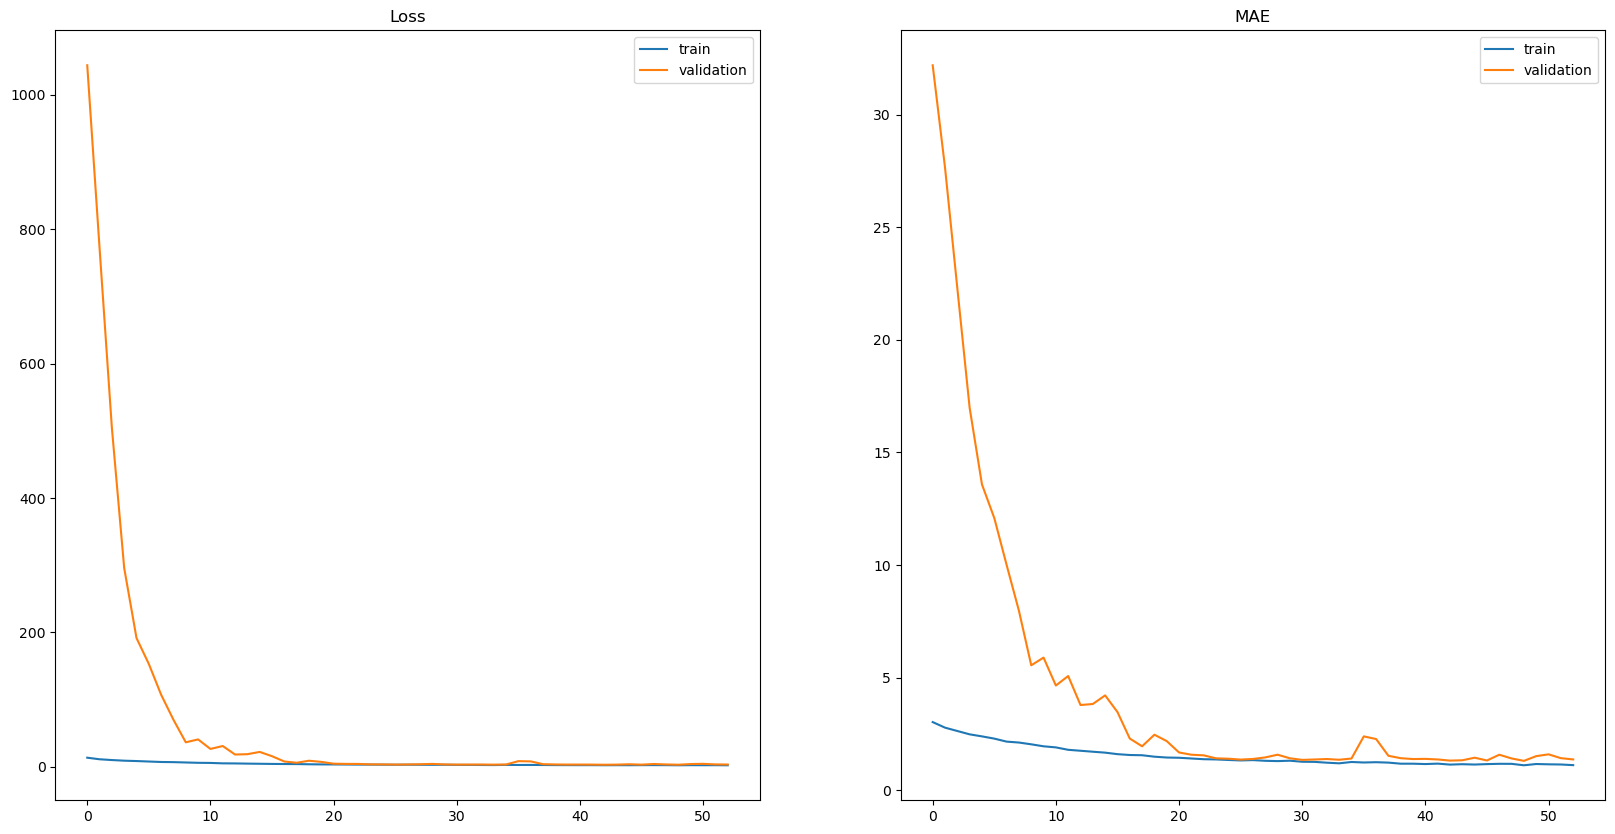

In [17]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.history.history['mae'], label='train')
plt.plot(model.history.history['val_mae'], label='validation')
plt.title('MAE')
plt.legend()
plt.show()

<div style="text-align: justify;">
The two graphs presented show the evolution of Loss (error) and Mean Absolute Error (MAE) during the training and validation of the model over 50 epochs - the graph on the left represents Loss (error) and the graph on the right represents Mean Absolute Error (MAE). Analysing the Loss graph, it can be seen that the training error decreases rapidly in the first few epochs and stabilises at a low value, indicating that the model has learned the patterns in the training data well. However, the validation error, despite decreasing initially, stabilises at a significantly higher value than the training error. This behaviour suggests that the model is overfitting, i.e. it is adjusting too much to the training data and is unable to generalise well to the validation data.


A similar pattern can be seen in the MAE graph, which measures the average of the absolute errors between the predictions and the actual values. The MAE for the training data decreases over time, stabilising at a low value, confirming that the model has good accuracy on the training data. However, for the validation data, the MAE starts at a high value, decreases rapidly in the first few epochs, but stabilises at a considerably higher value than the training one. This reinforces the presence of overfitting, since the model is not predicting the validation data as accurately as the training data.
</div>

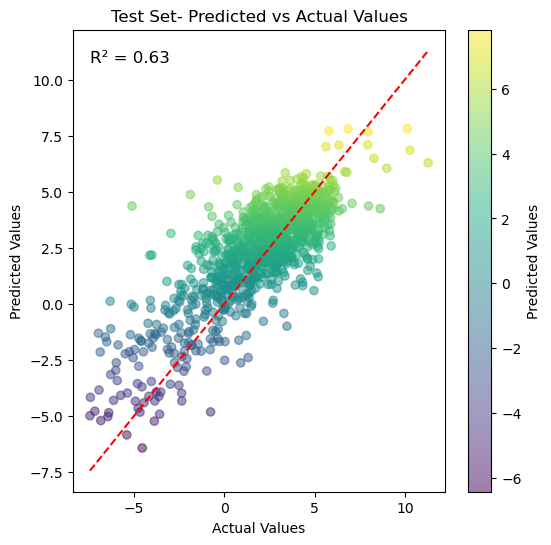

In [20]:
r2 = r2_score(y_test, predictions)

plt.figure(figsize=(6, 6))
sc = plt.scatter(y_test, predictions, c=predictions, cmap='viridis', alpha=0.5)
plt.colorbar(sc, label='Predicted Values')  
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Test Set- Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.text(min(y_test), max(y_test), f'R² = {r2:.2f}', fontsize=12, verticalalignment='top')

plt.show()

<div style="text-align: justify;">
The graph shown is a scatter plot that compares the actual values (Actual Values) with the values predicted by the model (Predicted Values) in the test set. This graph also includes the R² (coefficient of determination) metric, which quantifies the proportion of the variance in the actual values explained by the model. In the case of this model, the R² value is 0.63, which means that approximately 63 per cent of the variance in the actual values was explained by the predictions. Although this value indicates moderate performance, it suggests that the model has captured some of the underlying relationships in the data, but there is still room for improvement.

In terms of the general pattern, there is a linear trend in the graph, with the points lining up around the red diagonal line (which represents the ideal situation where the actual values are equal to the predicted ones, i.e. y_test = predictions). However, there are significant variations, especially at the upper and lower ends of the graph, indicating that the model has difficulty predicting extreme values accurately. The density of points is greatest in the central region, suggesting that the model works best for average values, while the deviations are more pronounced for higher or lower IC50 values.

Analysing the residuals (or forecast errors) reveals both positive and negative deviations. Some points are above the ideal line (indicating that the predicted values are higher than the actual ones) and others below (predicted values lower than the actual ones).

The colouring of the graph, which varies from darker shades (low predicted values) to lighter shades (high predicted values), provides an additional layer of visual information. However, there doesn't seem to be a clear relationship between the colouring and the alignment of the points on the diagonal line, which indicates that the extreme predicted values (represented by lighter or darker shades) are often the furthest from the ideal line.
</div>

In [23]:
print('Dense model')
print('MAE: ', mean_absolute_error(y_test, predictions))
print('MSE: ', mean_squared_error(y_test, predictions))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predictions)))
print('R2: ', r2_score(y_test, predictions))

Dense model
MAE:  1.327442830433562
MSE:  3.0474019402382613
RMSE:  1.7456809388425656
R2:  0.6299350282489279


<div style="text-align: justify;">
Based on the results presented, the performance of the DenseModel can be assessed using four main metrics: MAE, MSE, RMSE and R².

The Mean Absolute Error (MAE) is 1.33, which indicates that, on average, the model gets about 1.33 units wrong when predicting IC50 values. This performance is acceptable, but could be improved, especially for extreme values, where larger errors may be more critical. The Mean Squared Error (MSE), which measures the average squared error, shows a value of 3.05. As the MSE penalises larger errors more strongly due to squaring, this value suggests that there are some predictions with significant deviations that are increasing the overall average error. This is in line with the analysis of the previous graph, where it was identified that the most significant deviations occur for extreme values.

The Root Mean Squared Error (RMSE), which is the square root of the MSE, has a value of 1.75. This metric is more interpretable as it is on the same scale as the real IC50 values. The fact that the RMSE is slightly higher than the MAE confirms that larger errors (outliers) have a significant impact on the model's performance, increasing the overall average error.

Finally, the Coefficient of Determination (R²) is 0.63, which means that the model manages to explain 63 per cent of the variance in the actual IC50 values. This is a moderate performance, indicating that the model has captured a considerable part of the relationships in the data. However, around 37% of the variance in the data was not explained by the model, suggesting that there is still room for improvement in its ability to generalise.
</div>

### Bibliography


**Baptista, D., Ferreira, P. G., & Rocha, M.** (2022).  
*A systematic evaluation of deep learning methods for the prediction of drug synergy in cancer*.  
**Cold Spring Harbor Laboratory**. https://doi.org/10.1101/2022.05.16.492054  

[Full text](https://www.biorxiv.org/content/early/2022/05/16/2022.05.16.492054.full.pdf)
